In [1]:
import os
import csv
import scipy
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import episcanpy.api as epi
import warnings
from sklearn.feature_extraction.text import TfidfTransformer
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = "retina"

In [2]:
os.chdir("/data/proj/GCB_MK/CZI/episcanpy_analysis/AGG_ATAC_210218")

In [76]:
adata = ad.read("data/210301_RESULTS_2kb_binned_count_matrix.h5ad")

In [77]:
adata = ad.read("data/populated_binned_2kb_count_matrix.h5ad")
if np.max(adata.X) > 1:
    epi.pp.binarize(adata)
if "barcode" not in adata.obs.columns:
    adata.obs["barcode"] = adata.obs_names

### Initial filtering
Select top 20,000 features  
Remove lowest 10% of cells (by nb_features)

In [79]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)
adata.obs["log_nb_features"] = [np.log10(x) for x in adata.obs["nb_features"]]
##filter out lowest 10% of cells
min_features = np.quantile(adata.obs["nb_features"], 0.1)
epi.pp.filter_cells(adata, min_features=min_features)
## select top 20,000 features
min_cells = np.sort(adata.var["n_cells"])[-20000]
adata = adata[:, adata.var["n_cells"] >= min_cells]

#### TF-IDF normalization, SVD dimensionality reduction

In [80]:
X = adata.X
tfidf = TfidfTransformer(use_idf=True)
X_norm = tfidf.fit_transform(X)
adata.X = X_norm

In [81]:
sc.tl.pca(adata, zero_center=False, n_comps=51)

#### Remove the first PC

In [83]:
adata.obsm["X_pca_all"] = adata.obsm["X_pca"]
adata.obsm["X_pca"] = adata.obsm["X_pca"][:,1:]
adata.uns["pca"]["variance_ratio"] = adata.uns["pca"]["variance_ratio"][1:]
adata.uns["pca"]["variance"] = adata.uns["pca"]["variance"][1:]

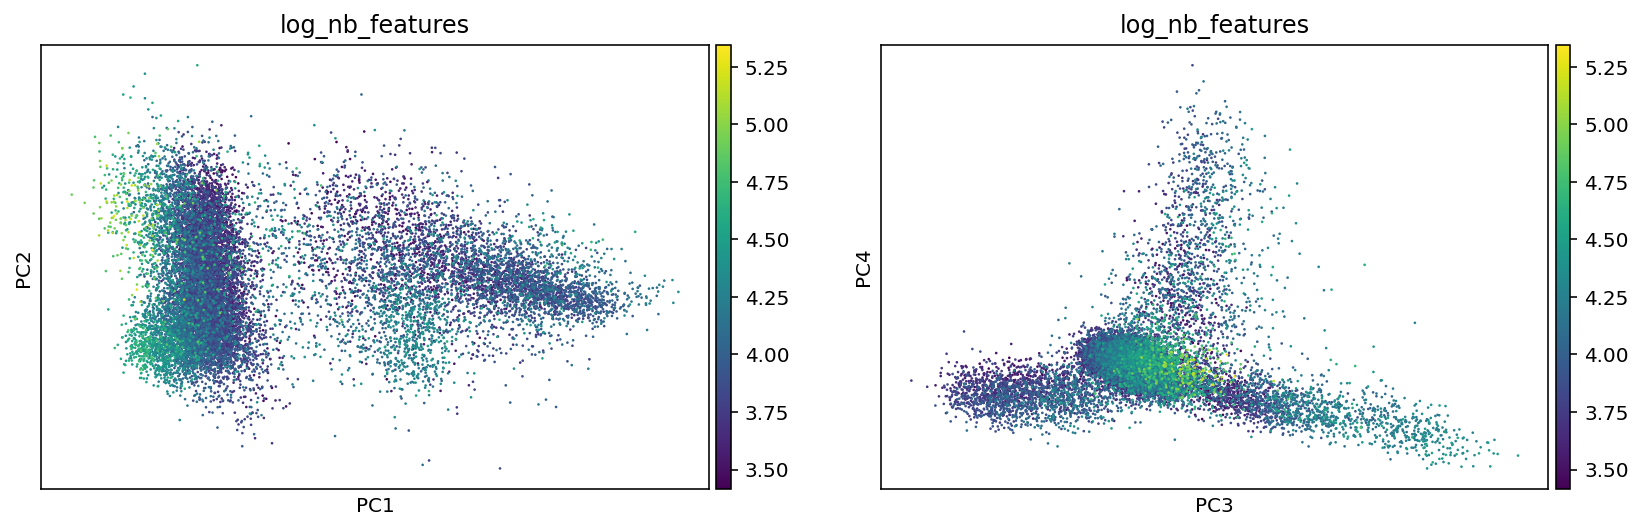

In [105]:
sc.pl.pca(adata, color="log_nb_features", components = ['1,2','3,4'])

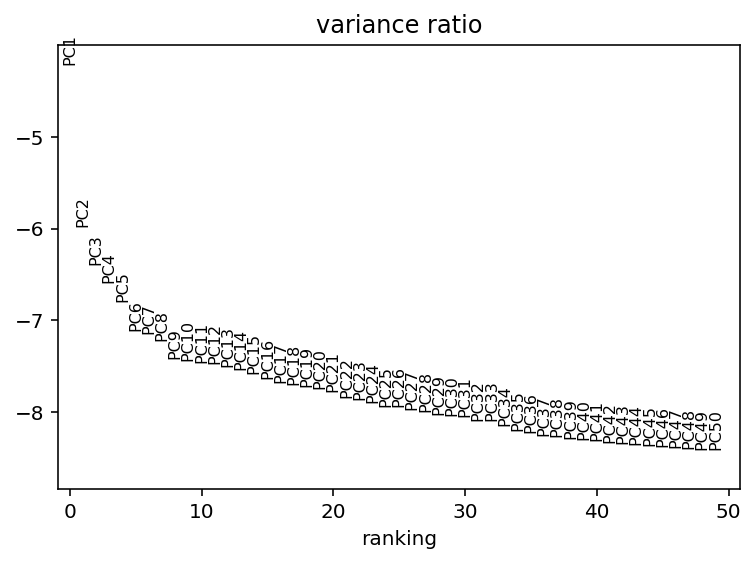

In [102]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [106]:
sc.pp.neighbors(adata, n_pcs = 50, n_neighbors = 15, metric="cosine")
sc.tl.umap(adata, n_components=2)
epi.tl.louvain(adata)

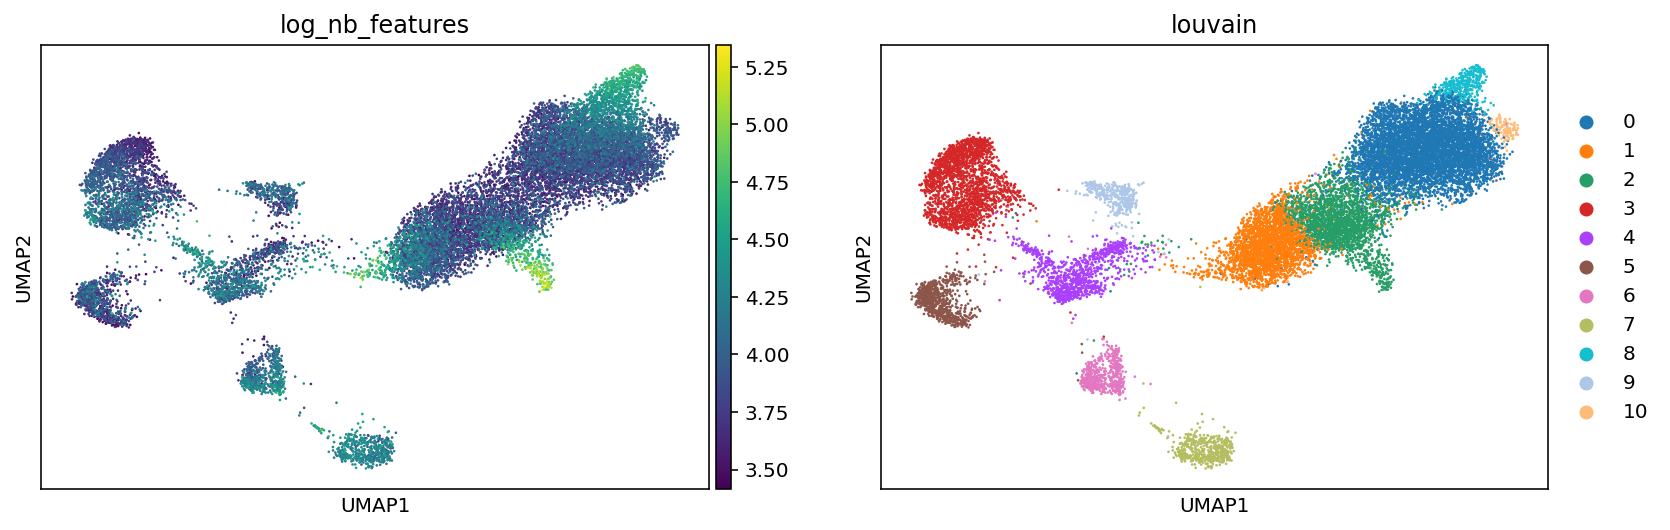

In [124]:
sc.pl.umap(adata, color=["log_nb_features", "louvain"])

#### Extract cluster IDs for cells as .csv

In [120]:
bc_cluster_df = adata.obs[["barcode","louvain"]]
bc_cluster_df.to_csv("data/barcodes_by_louvain_cluster_LSI-1.csv", header=False, index=False)

### Write to results file

In [126]:
adata.write("data/210301_LSI-1_RESULTS_2kb_bin_matrix.h5ad")